In [1]:
import numpy as np
import healpy as hp
import pyccl as ccl
import matplotlib.pyplot as plt

plt.style.use("seaborn-notebook")

In [2]:
#read in map
#kappa_16348 = np.load("/mnt/store1/tkarim/cmb_lensing/data/Abacus/no_neutrino/base_c009_ph000/kappa_nested.npy")

In [3]:
#converg nested map to ring 
#kappa_16348 = hp.reorder(kappa_16348, n2r = True)

Degrade masks from 16384 to 2048.

In [4]:
NSIDE = 2048
#kappa_2048 = hp.ud_grade(kappa_16348, nside_out=NSIDE)
#save the mask for future
#hp.write_map("/mnt/store1/tkarim/cmb_lensing/data/Abacus/no_neutrino/base_c009_ph000/kappa_ring_2048.fits", kappa_2048, partial=True)
kappa_2048 = hp.read_map("/mnt/store1/tkarim/kappa_ring_2048.fits")

#mask = np.load("/mnt/store1/tkarim/mask_ring.npy")
#mask_2048 = hp.ud_grade(mask, nside_out=NSIDE)
#mask_2048[mask_2048 != 0] = 1 #set all non-zero coarser pixels to 1 to make it a bool map

#save the mask for future
#hp.write_map("/mnt/store1/tkarim/mask_2048.fits", mask_2048, partial=True)
mask_2048 = hp.read_map("/mnt/store1/tkarim/mask_2048.fits")

/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/tkarim/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = EXPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


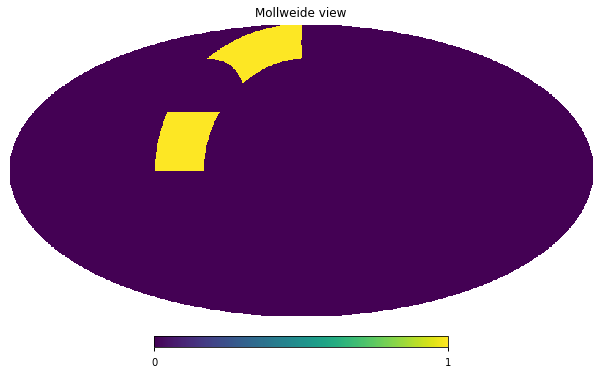

In [5]:
hp.mollview(mask_2048)

Compare mask with Boryana's 

In [5]:
mask_2048_b = np.load("/mnt/store1/boryanah/AbacusSummit_base_c000_ph006/light_cones/mask_ring_2048.npy")

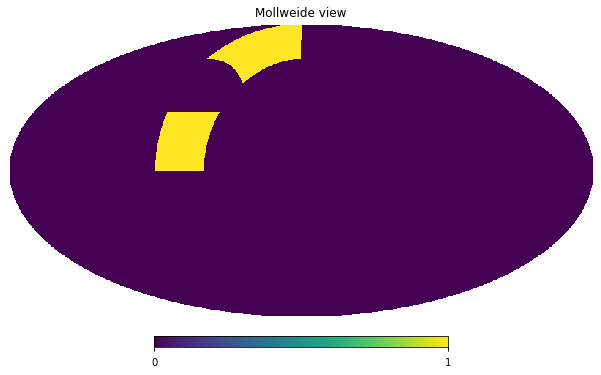

In [6]:
hp.mollview(mask_2048_b)

In [7]:
(np.sum(mask_2048) - np.sum(mask_2048_b))/np.sum(mask_2048)

0.002216418602431939

**Note**: $4924$ ($\sim 0.22 \%$) fewer pixels are masked using the `hp.ud_grade` operation. 

Compare full resolution map with the `NSIDE=2048` map

In [8]:
#hp.mollview(kappa_16348, cmap = 'inferno')

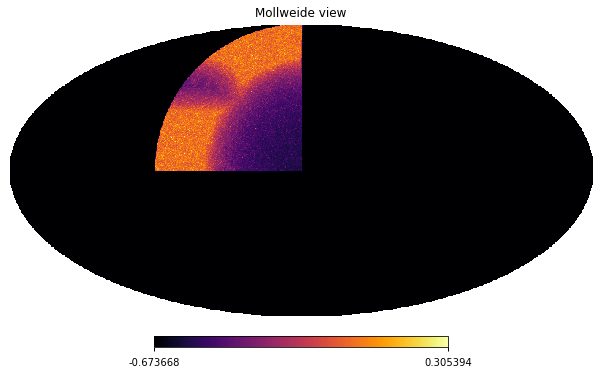

In [6]:
hp.mollview(kappa_2048, cmap = 'inferno')

Apply mask to data array

In [7]:
#kappa_masked_16384 = hp.ma(kappa_16348)
#kappa_masked_16384.mask = np.logical_not(mask)

kappa_masked_2048 = hp.ma(kappa_2048)
kappa_masked_2048.mask = np.logical_not(mask_2048)

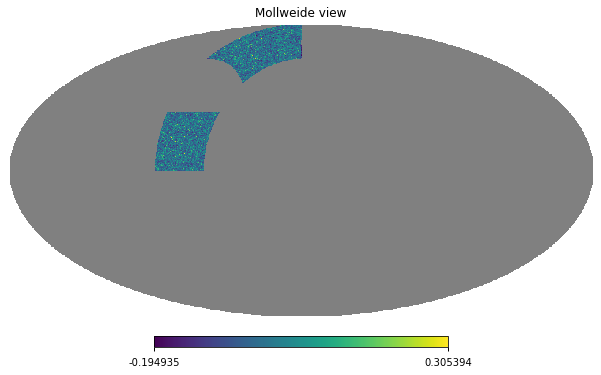

In [8]:
hp.mollview(kappa_masked_2048)

In [9]:
# check mean and std for consistency
#print(f'NSIDE=16384; Mean: {np.mean(kappa_masked_16384)}, std: {np.std(kappa_masked_16384)}')
print(f'NSIDE=2048; Mean: {np.mean(kappa_masked_2048)}, std: {np.std(kappa_masked_2048)}')

NSIDE=2048; Mean: -0.0030554660955945186, std: 0.058375067051311166


Calculate $f_{sky}$

In [10]:
fsky = np.sum(mask_2048)/kappa_2048.size
print(fsky)

0.04413926601409912


Calculate pseudo-$C_l$ 

In [11]:
clkk_2048 = hp.anafast(kappa_masked_2048, lmax=1024)

Text(0.5, 1.0, 'NSIDE = 2048')

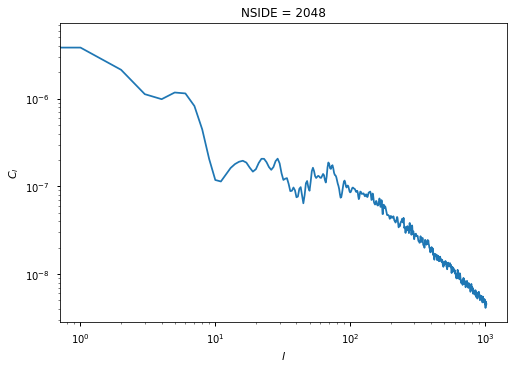

In [12]:
plt.loglog(clkk_2048/fsky)
plt.xlabel(r"$l$")
plt.ylabel(r"$C_{l}$")
plt.title("NSIDE = 2048")

## Compare with Theory

Binning function

In [13]:
import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

Setup CCL to produce $C_l$s according to the ini file of this simulation:

In [14]:
#define cosmology; not specified alpha_s = 0.0, N_ur = 2.0328, N_ncdm = 1.0, omega_ncdm = 0.0006442
#https://github.com/abacusorg/AbacusSummit/blob/master/Cosmologies/abacus_cosm000/CLASS.ini
cosmo = ccl.Cosmology(Omega_c = 0.26447, Omega_b = 0.04930, \
        h = 0.6736, n_s = 0.9649, A_s=2.083e-9, \
        w0 = -1.0, wa = 0.0)

In [15]:
#calculate theoretical Cls
lmax = 1024
ell = np.arange(0, lmax, 1) #lmax = 1500
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(ell, cls_cmb, ELL)

fltr = (tmp[0] > 100)
ELL_th = tmp[0][fltr]
cLkk_th = tmp[1][fltr]

<ipython-input-13-8b96a7f64b3c>:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


In [16]:
#bin AbacusSummit data
ELL = np.arange(0, lmax+1, 100)
tmp = bin_mat(np.arange(0, lmax+1, 1), clkk_2048, ELL)

fltr = (tmp[0] > 100)
ELL_abacus = tmp[0][fltr]
cLkk_abacus = tmp[1][fltr]

<ipython-input-13-8b96a7f64b3c>:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


In [17]:
ELL_abacus

array([150., 250., 350., 450., 550., 650., 750., 850., 950.])

(array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05]),
 <a list of 6 Text major ticklabel objects>)

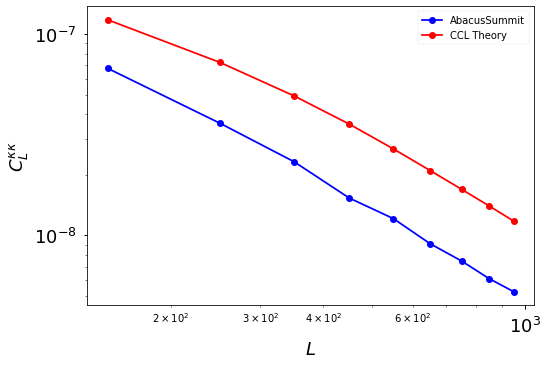

In [18]:
fs = 18 

plt.loglog(ELL_abacus, cLkk_abacus/fsky, 'bo-', label = 'AbacusSummit')
plt.yscale('log')
plt.xscale('log')
plt.plot(ELL_th, cLkk_th, 'ro-', label = 'CCL Theory')
plt.legend( loc = 'best')
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$C^{\kappa \kappa}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

In [31]:
skylens_lb = np.array([150., 250., 350., 450., 550., 650., 750., 850., 950.])

skylens_cl = np.array([2.77628953e-09, 1.65282038e-09, 1.03846244e-09, 7.26019018e-10,
       5.38522564e-10, 4.15026534e-10, 3.35007658e-10, 2.75570372e-10,
       2.31031813e-10])

In [20]:
cLkk_abacus

array([2.98436168e-09, 1.59208922e-09, 1.02584562e-09, 6.76985059e-10,
       5.34959849e-10, 4.01468676e-10, 3.29359846e-10, 2.69317428e-10,
       2.32066641e-10])

In [21]:
plt.loglog(skylens_lb, skylens_cl, 'ro-', label = 'Skylens Theory')
plt.loglog(ELL_abacus, cLkk_abacus, 'g*-', label = 'AbacusSummit')
#plt.loglog(ELL_th, cLkk_th, 'bo-', label = 'CCL Theory')
plt.legend( loc = 'best')
plt.xlabel('$L$',fontsize=fs)
plt.ylabel('$\~{C}^{\kappa \kappa}_{L}$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

NameError: name 'skylens_lb' is not defined

Text(0, 0.5, '$\\frac{(C_{L}^{Abacus} - C_{L}^{Skylens})}{C_{L}^{Skylens}}$')

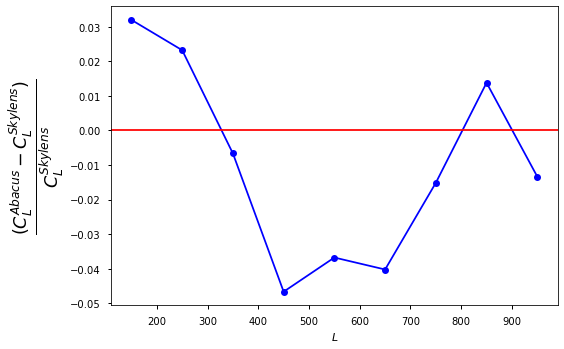

In [33]:
plt.plot(skylens_lb, (cLkk_abacus - skylens_cl)/skylens_cl, 'bo-')
plt.axhline(0, c = 'r')
plt.xlabel(r"$L$")
plt.ylabel(r"$\frac{(C_{L}^{Abacus} - C_{L}^{Skylens})}{C_{L}^{Skylens}}$", fontsize = 25)

In [34]:
np.mean((cLkk_abacus - skylens_cl)/skylens_cl)

-0.00997571370131991

In [35]:
np.std((cLkk_abacus - skylens_cl)/skylens_cl)

0.026766859354728893